### **Install Ludwig and Ludwig's LLM related dependencies.**

In [1]:
%pip uninstall -y tensorflow --quiet
%pip install --upgrade git+https://github.com/huggingface/transformers
# %pip install transformers==4.30
%pip install --upgrade git+https://github.com/huggingface/peft.git
# %pip install peft==1.0.0
%pip install git+https://github.com/ludwig-ai/ludwig.git@master --quiet
# %pip install ludwig==0.3.2

Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/huggingface/transformers to /private/var/folders/zl/s4y0gzxx4yn2bfs8b99txw580000gn/T/pip-req-build-e98k9v5b
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /private/var/folders/zl/s4y0gzxx4yn2bfs8b99txw580000gn/T/pip-req-build-e98k9v5b
  Resolved https://github.com/huggingface/transformers to commit 08a2edfc6629a323effd7a85feafed9e6701e2dd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/huggingface/peft.git to /private/var/folders/zl/s4y0gzxx4yn2bfs8b99txw580000gn/T/pip-req-build-nht2bnr6
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/peft.git /private/var/folders/zl/s4y0gzxx4yn2bfs8b99txw580000gn/T/pip-req-build-nht2bnr6
  R

In [2]:
%pip install --upgrade datasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install py7zr

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install xformers

Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip show torch

Name: torch
Version: 2.1.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /opt/homebrew/lib/python3.11/site-packages
Editable project location: /opt/homebrew/lib/python3.11/site-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: accelerate, ludwig, peft, torchaudio, torchdata, torchmetrics, torchtext, torchvision, xformers
Note: you may need to restart the kernel to use updated packages.


In [6]:
%pip show transformers

Name: transformers
Version: 4.35.0.dev0
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /opt/homebrew/lib/python3.11/site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: ludwig, peft
Note: you may need to restart the kernel to use updated packages.


In [7]:

import os

import copy

import gc

from typing import Any, Callable

import time

from functools import wraps
from inspect import (
    BoundArguments,
    signature,
)

from collections import OrderedDict

import yaml

import numpy as np
import pandas as pd

import torch
from torch import Tensor

import datasets
from datasets import load_dataset, Dataset, DatasetDict

import transformers
from transformers import BitsAndBytesConfig, AutoModelForCausalLM, LlamaForCausalLM, MistralForCausalLM, AutoTokenizer, LlamaTokenizerFast, GenerationConfig, TextGenerationPipeline, BatchEncoding
from transformers.generation.utils import GreedySearchDecoderOnlyOutput

from peft import PeftModel, PeftModelForCausalLM, PeftConfig, LoraConfig

from ludwig.api import LudwigModel, TrainingResults


import logging

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/lib/python3.11/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


Enable text wrapping so we don't have to scroll horizontally and create a function to flush CUDA cache.

In [8]:
from IPython.display import HTML, display

def set_css() -> None:
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))

get_ipython().events.register('pre_run_cell', set_css)


In [9]:
def predict(model: LudwigModel, df_test: pd.DataFrame) -> list[list[str]]:
  return model.predict(df_test)[0]['summary_response'].tolist()

### **Setup Your HuggingFace Token** 🤗

Obtain a [HuggingFace API Token](https://huggingface.co/settings/tokens) before proceeding. You may need to signup on HuggingFace if you do not aleady have an account: https://huggingface.co/join


In [10]:
import getpass
# import locale; locale.getpreferredencoding = lambda: 'UTF-8'
import logging
import os
import torch
import yaml

import locale
def getpreferredencoding(do_setlocale = True):
    return 'UTF-8'

locale.getpreferredencoding = getpreferredencoding


os.environ['HUGGING_FACE_HUB_TOKEN'] = getpass.getpass('Token:')
assert os.environ['HUGGING_FACE_HUB_TOKEN']

### **Import The Dataset** 📋



In [11]:
import datasets
from datasets import load_dataset, Dataset, DatasetDict

In [12]:
dataset_dict: DatasetDict = datasets.load_dataset('databricks/databricks-dolly-15k')
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 15011
    })
})

In [13]:
from sklearn.model_selection import train_test_split
df = pd.DataFrame(dataset_dict['train'].to_pandas())
[df_train, test_dataset] = train_test_split(df,train_size = 0.9)
[df_test, df_validation] = train_test_split(test_dataset,train_size = 0.5)

In [14]:
df_evaluation: pd.DataFrame = df_train.sample(n=10, random_state=200)
df_train = df_train.drop(df_evaluation.index)

In [15]:
df_train = df_train.sample(n=700, random_state=200)
df_test = df_test.sample(n=200, random_state=200)
df_validation = df_validation.sample(n=100, random_state=200)

In [16]:
assert df_train.shape[0] == 700
assert df_test.shape[0] == 200
assert df_validation.shape[0] == 100

In [17]:
df_train['split'] = np.zeros(df_train.shape[0])
df_test['split'] = np.ones(df_test.shape[0])
df_validation['split'] = np.full(df_validation.shape[0], 2)

In [18]:
df_dataset = pd.concat([df_train, df_test, df_validation])

In [19]:
df_dataset['split'] = df_dataset['split'].astype(int)

In [20]:
df_dataset.shape

(1000, 5)

In [21]:
assert df_dataset[df_dataset['split'] == 0].shape[0] == 700
assert df_dataset[df_dataset['split'] == 1].shape[0] == 200
assert df_dataset[df_dataset['split'] == 2].shape[0] == 100

In [22]:
df_dataset.head(10)

,instruction,context,response,category,split
14910,What is the difference between walking and run...,,Walking and running involves taking steps to g...,open_qa,0
13055,Who is the protagonist in Italo Calvino's Invi...,"""The book explores imagination and the imagina...",The book explores imagination and the imaginab...,closed_qa,0
13640,What is the best wideangle lens for sony apec ...,,Sigma DC DN 16MM 1.4 . The picture quality is ...,brainstorming,0
13059,Should I go to the beach or mountains for my n...,,We have vacation homes in many locations to fi...,creative_writing,0
4691,How can I run Spark on a cluster?,,"You can use either the standalone deploy mode,...",general_qa,0
3777,"What type of animal was: Hobbes, Snoopy, Garfi...",,Hobbes was a tiger. Snoopy was a dog. Garfield...,classification,0
4640,What are the words of House Tarly?,,"""First in Battle""",open_qa,0
10906,What is impala?,,The impala or rooibok is a medium-sized antelo...,open_qa,0
4005,What happened in Woodstock,"Woodstock Music and Art Fair, commonly referre...","The Woodstock Music and Art Fair, commonly ref...",summarization,0
8353,Give me 5 great landmarks to visit in the west...,,- The Grand Canyon\n- Mount Rainier\n- The Gol...,brainstorming,0


In [23]:
%pip install matplotlib


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Average number of tokens in the instruction column: 24
Average number of tokens in the context column: 134
Average number of tokens in the response column: 117


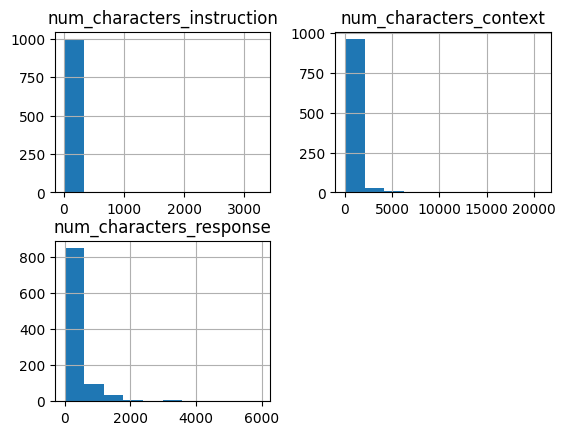

In [24]:
# Calculating the length of each cell in each column
df_dataset['num_characters_instruction'] = df_dataset['instruction'].apply(lambda x: len(x))
df_dataset['num_characters_context'] = df_dataset['context'].apply(lambda x: len(x))
df_dataset['num_characters_response'] = df_dataset['response'].apply(lambda x: len(x))

# Show Distribution
df_dataset.hist(column=['num_characters_instruction', 'num_characters_context', 'num_characters_response'])

# Calculating the average
average_chars_instruction = df_dataset['num_characters_instruction'].mean()
average_chars_context = df_dataset['num_characters_context'].mean()
average_chars_response = df_dataset['num_characters_response'].mean()

print(f'Average number of tokens in the instruction column: {(average_chars_instruction / 3):.0f}')
print(f'Average number of tokens in the context column: {(average_chars_context / 3):.0f}')
print(f'Average number of tokens in the response column: {(average_chars_response / 3):.0f}')


In [25]:
df_evaluation

,instruction,context,response,category
7421,Where can I buy leather pants for women?,,You can find leather pants at a variety of ret...,brainstorming
1195,Tell me which of the following activities are ...,,Working out typically involves movement of the...,classification
8830,How do you thicken bolognese sauce?,,You can use flour or cornstarch to thicken you...,open_qa
8478,Who wrote the second episode of season four of...,,"George R.R. Martin wrote ""The Lion and the Ros...",open_qa
13709,What are the advantages of a propane grill?,,The most often cited advantage of a propane gr...,open_qa
2810,Who are some important people in U.S. history ...,,Here are some important people in U.S. history...,brainstorming
7470,Tell me whether these animals are domesticated...,,"Cats, dogs, and sheep are domesticated. Bald e...",classification
14173,Based on the passage list the four companies a...,Apple Inc. is an American multinational techno...,"Alphabet, Amazon, Meta, Microsoft",information_extraction
2653,What is the minimal set of garden tools to sta...,,"For an outdoor garden, you only need a spade, ...",brainstorming
9244,How many Children Trump has?,"In 1977, Trump married Czech model Ivana Zelní...",From his marriages he has 5 children from thre...,closed_qa


In [26]:
prompt_template: str = '''
Respond to this instruction with the given context:

### Context: {context}

### Instruction: {instruction}

### Synopsis:
'''

In [27]:
test_context: str = '''
A list of American Presidents in chronological order:
1. George Washington
2. John Adams
3. Thomas Jefferson
4. James Madison
5. James Monroe
6. John Quincy Adams
7. Andrew Jackson
8. Martin Van Buren
9. William Henry Harrison
10. John Tyler
11. James K. Polk
12. Zachary Taylor
13. Millard Fillmore
14. Franklin Pierce
15. James Buchanan
16. Abraham Lincoln
17. Andrew Johnson
18. Ulysses S. Grant
19. Rutherford B. Hayes
20. James A. Garfield
21. Chester A. Arthur
22. Grover Cleveland
23. Benjamin Harrison
24. Grover Cleveland
25. William McKinley
26. Theodore Roosevelt
27. William Howard Taft
28. Woodrow Wilson
29. Warren G. Harding
30. Calvin Coolidge
31. Herbert Hoover
32. Franklin D. Roosevelt
33. Harry S. Truman
34. Dwight D. Eisenhower
35. John F. Kennedy
36. Lyndon B. Johnson
37. Richard Nixon
38. Gerald Ford
39. Jimmy Carter
40. Ronald Reagan
41. George H. W. Bush
42. Bill Clinton
43. George W. Bush
44. Barack Obama
45. Donald Trump
46. Joe Biden
'''

In [28]:
test_instruction: str = '''
What is the 16th President of the United States of America?
'''

In [29]:
test_prompt: str = prompt_template.format(**{'context': test_context, 'instruction': test_instruction})

In [30]:
mistral_7b_sharded_base_model_name: str = 'alexsherstinsky/Mistral-7B-v0.1-sharded'

In [31]:
mistral_7b_sharded_base_model_name: str = 'mistralai/Mistral-7B-v0.1'

Load the pre-trained (general) Mistral 7B LLM (the sharded version).

In [32]:
bnb_config_base_model: BitsAndBytesConfig = BitsAndBytesConfig(
    load_in_8bit=True,
)

In [33]:
base_model_tokenizer: LlamaTokenizerFast = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=mistral_7b_sharded_base_model_name, trust_remote_code=True, padding_side='left')
print(base_model_tokenizer.eos_token)
base_model_tokenizer.pad_token = base_model_tokenizer.eos_token

</s>


In [34]:
%pip install accelerate
%pip install -i https://test.pypi.org/simple/ bitsandbytes


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://test.pypi.org/simple/

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [35]:
base_model: MistralForCausalLM = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=mistral_7b_sharded_base_model_name, device_map='auto', torch_dtype=torch.float16, offload_folder='offload', trust_remote_code=True, low_cpu_mem_usage=True, quantization_config=bnb_config_base_model)

KeyboardInterrupt: 

Run inference on the pre-trained (general) Mistral 7B LLM to establish baseline quality.

In [ ]:
base_model_sequences_generator: TextGenerationPipeline = transformers.pipeline(
    task='text-generation',
    tokenizer=base_model_tokenizer,
    model=base_model,
    torch_dtype=torch.float16,
    device_map='auto',
)

NameError: name 'base_model' is not defined

In [ ]:
base_model_sequences: list[dict] | list[list[dict]] = base_model_sequences_generator(
    text_inputs=samsum_test_prompt,
    do_sample=True,
    top_k=50,
    num_return_sequences=1,
    eos_token_id=base_model_tokenizer.eos_token_id,
    max_length=512,
    return_text=True,
)

In [ ]:
base_model_sequence: dict = base_model_sequences[0]

In [ ]:
print(f'\n[GENERATED_TEXT] BASE_MODEL_PREDICTION:\n{base_model_sequence['generated_text']} ; TYPE: {str(type(base_model_sequence['generated_text']))}')

In [ ]:
gc.collect()

Run inference on the pre-trained (general) Mistral 7B LLM over the evaluation dataset.

In [ ]:
df_samsum_evaluation: pd.DataFrame = df_evaluation.copy()

In [ ]:
df_samsum_evaluation['prompt'] = df_samsum_evaluation['dialogue'].apply(lambda x: samsum_prompt_template.format(**{'dialogue': x}))

In [ ]:
base_model_sequences = base_model_sequences_generator(
    text_inputs=df_samsum_evaluation['prompt'].to_list(),
    do_sample=True,
    top_k=50,
    num_return_sequences=1,
    eos_token_id=base_model_tokenizer.eos_token_id,
    max_length=512,
    return_text=True,
)

In [ ]:
print(f'\n[BASE_MODEL_EVALUATION_BEGIN]')
idx: int = 0
print(f'\n[=============EXAMPLE_{idx}_BEGIN=============]')
for dialogue, synopsis in zip(df_samsum_evaluation['dialogue'].to_list(), base_model_sequences):
  print(f'\n[BASE_MODEL_EVALUATION] GENERATED_SUMMARY:\n{synopsis[0]['generated_text']}')
  print(f'\n[=============EXAMPLE_{idx}_END=============]')
  idx += 1

print(f'\n[BASE_MODEL_EVALUATION_END]')

In [ ]:
gc.collect()

Configure and execute finetuning process.

In [ ]:
qlora_fine_tuning_config: dict = yaml.safe_load(
'''
model_type: llm
base_model: alexsherstinsky/Mistral-7B-v0.1-sharded

input_features:
  - name: dialogue
    type: text
    preprocessing:
      max_sequence_length: 1024

output_features:
  - name: summary
    type: text
    preprocessing:
      max_sequence_length: 384

prompt:
  template: >-
    Summarize this dialogue:

    ### Dialogue: {dialogue}

    ### Synopsis:

generation:
  temperature: 0.1
  max_new_tokens: 512

adapter:
  type: lora
  postprocessor:
    merge_adapter_into_base_model: true
    progressbar: true

quantization:
  bits: 8

preprocessing:
  split:
    # type: random
    # probabilities: [0.9, 0.05, 0.05]
    type: fixed

trainer:
  type: finetune
  epochs: 5
  batch_size: 1
  eval_batch_size: 2
  gradient_accumulation_steps: 16  # effective batch size = batch size * gradient_accumulation_steps
  learning_rate: 2.0e-4
  enable_gradient_checkpointing: true
  learning_rate_scheduler:
    decay: cosine
    warmup_fraction: 0.03
    reduce_on_plateau: 0
'''
)

In [ ]:
model: LudwigModel = LudwigModel(config=qlora_fine_tuning_config, logging_level=logging.INFO)

In [ ]:
results: TrainingResults = model.train(dataset=df_dataset)

#### Perform Inference

We can now use the model we finetuned above to make predictions on some test examples to see whether finetuning the large language model improve its ability to follow instructions/the tasks we're asking it to perform.

In [ ]:
predictions_and_probabilities: tuple[pd.DataFrame, pd.DataFrame] = model.predict(df_evaluation)

In [ ]:
df_predictions: pd.DataFrame = predictions_and_probabilities[0]

In [ ]:
df_predictions.columns

In [ ]:
print('\n\n')
for dialogue_with_summary in zip(df_evaluation['dialogue'], df_predictions['summary_response']):
  print(f'Dialogue:\n{dialogue_with_summary[0]}')
  print(f'Generated Summary:\n{dialogue_with_summary[1][0]}')
  print('\n\n')

In [ ]:
df_control_example: pd.DataFrame = pd.DataFrame(
    data={
      'dialogue': [samsum_test_dialogue,],
    }
)
df_control_example

In [ ]:
predictions: list[list[str]] = predict(model=model, df_test=df_control_example)

In [ ]:
one_prediction: str = predictions[0][0]
print(f'\n[GENERATED_TEXT] PREDICTION:\n{one_prediction}')

# **Upload Trained Model Artifacts To HuggingFace** 🤗

Now that we have a fine-tuned model, we can export the model weights to HuggingFace hub so we can use them in downstream tasks or in production. Ludwig supports uploading model weights directly to HuggingFace Hub via the `upload` Ludwig command.

```
!ludwig upload hf_hub --repo_id <hf_user_name>/<repo_name> --model_path <top_level_model_directory>
```

In [ ]:
!ludwig upload hf_hub --repo_id 'alexsherstinsky/mistralai-7B-v01-based-finetuned-using-ludwig-with-samsum-A100-sharded-8bit-merged' --model_path /content/results/api_experiment_run

In [ ]:
samsum_fine_tuned_model_name: str = 'alexsherstinsky/mistralai-7B-v01-based-finetuned-using-ludwig-with-samsum-A100-sharded-8bit-merged'

In [ ]:
gc.collect()

Load the finetuned LoRA layers for Mistral 7B LLM (adapter weights for SAMSum dataset).

In [ ]:
print(f'\n[LOADING_MODEL] FINE_TUNED_AND_MERGED:\n{samsum_fine_tuned_model_name}')
samsum_tokenizer: LlamaTokenizerFast = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=samsum_fine_tuned_model_name, trust_remote_code=True, padding_side='left')
bnb_config_samsum_fine_tuned_model: BitsAndBytesConfig = BitsAndBytesConfig(
  load_in_8bit=True,
)
samsum_model: MistralForCausalLM = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=samsum_fine_tuned_model_name, torch_dtype=torch.float16, trust_remote_code=True, device_map='auto', quantization_config=bnb_config_samsum_fine_tuned_model, low_cpu_mem_usage=True)

In [ ]:
gc.collect()

Run inference on finetuned Mistral 7B LLM for SAMSum dataset to verify quality.

In [ ]:
samsum_sequences_generator: TextGenerationPipeline = transformers.pipeline(
    task='text-generation',
    tokenizer=samsum_tokenizer,
    model=samsum_model,
    torch_dtype=torch.float16,
    device_map='auto',
)

In [ ]:
samsum_sequences: list[dict] | list[list[dict]] = samsum_sequences_generator(
    text_inputs=samsum_test_prompt,
    do_sample=True,
    top_k=50,
    num_return_sequences=1,
    eos_token_id=samsum_tokenizer.eos_token_id,
    max_length=512,
    return_text=True,
)

In [ ]:
samsum_sequence: dict = samsum_sequences[0]

In [ ]:
print(f'\n[GENERATED_TEXT] FINE_TUNED_MODEL_PREDICTION:\n{samsum_sequence['generated_text']} ; TYPE: {str(type(samsum_sequence['generated_text']))}')

In [ ]:
gc.collect()

Run inference on finetuned Mistral 7B LLM for SAMSum dataset over the evaluation dataset.

In [ ]:
df_samsum_evaluation: pd.DataFrame = df_evaluation.copy()

In [ ]:
df_samsum_evaluation['prompt'] = df_samsum_evaluation['dialogue'].apply(lambda x: samsum_prompt_template.format(**{'dialogue': x}))

In [ ]:
samsum_sequences: list[dict] | list[list[dict]] = samsum_sequences_generator(
    text_inputs=df_samsum_evaluation['prompt'].to_list(),
    do_sample=True,
    top_k=50,
    num_return_sequences=1,
    eos_token_id=samsum_tokenizer.eos_token_id,
    max_length=512,
    return_text=True,
)

In [ ]:
print(f'\n[FINE_TUNED_MODEL_EVALUATION_BEGIN]')
idx: int = 0
print(f'\n[=============EXAMPLE_{idx}_BEGIN=============]')
for dialogue, synopsis in zip(df_samsum_evaluation['dialogue'].to_list(), samsum_sequences):
  print(f'\n[FINE_TUNED_MODEL_EVALUATION] GENERATED_SUMMARY:\n{synopsis[0]['generated_text']}')
  print(f'\n[=============EXAMPLE_{idx}_END=============]')
  idx += 1

print(f'\n[FINE_TUNED_MODEL_EVALUATION_END]')